# Generating digits
From mnist

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


# Hyperparameters

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

# Size of the noise vector
z_dim = 100

# Generator

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    # Fully connected layer
    model.add(Dense(128, input_dim=z_dim))
    
    # Activation
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer
    model.add(Dense(img_rows * img_cols * channels, activation='tanh'))
    
    # Reshape the generator output to image dimensions
    model.add(Reshape(img_shape))
    
    return model

# Discriminator

In [4]:
def build_discriminator(img_shape):
    
    model = Sequential()
    
    # input image
    model.add(Flatten(input_shape=img_shape))
    
    model.add(Dense(128))
    
    # Activation
    model.add(LeakyReLU(alpha=0.01))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    return model

# Build the model

In [5]:
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    # Combined Generator <-> Discriminator
    model.add(generator)
    model.add(discriminator)
    
    return model

In [6]:
# Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Generator
generator = build_generator(img_shape, z_dim)

# Keeps discriminator's parameters constant for generator training
discriminator.trainable = False

# Build and compile
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iteractions, batch_size, sample_interval):
    (X_train, _), (_,_) = mnist.load_data()
    # Rescale mnist data from [0, 255] to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # Labels for real images
    real = np.ones((batch_size, 1))
    
    # Labels for fake images
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iteractions):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train the generator
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # Output a generated image sample
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_cols=4):
    # Random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_cols, z_dim))
    
    gen_imgs = generator.predict(z)
    
    # Rescale values to 0, 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_cols,
                           figsize=(4, 4),
                           sharey=True,
                           sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# Train the GAN and inspect output

/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/Users/stelling/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.027040, acc.: 100.00%] [G loss: 5.236525]
2000 [D loss: 0.158185, acc.: 93.75%] [G loss: 4.729728]
3000 [D loss: 0.171388, acc.: 92.97%] [G loss: 6.866333]
4000 [D loss: 0.133715, acc.: 95.70%] [G loss: 4.229237]
5000 [D loss: 0.194299, acc.: 93.75%] [G loss: 4.501631]
6000 [D loss: 0.237941, acc.: 91.02%] [G loss: 4.410504]
7000 [D loss: 0.160012, acc.: 92.58%] [G loss: 5.078610]
8000 [D loss: 0.454467, acc.: 82.81%] [G loss: 3.254516]
9000 [D loss: 0.216063, acc.: 92.58%] [G loss: 4.486645]
10000 [D loss: 0.258238, acc.: 91.41%] [G loss: 5.404964]
11000 [D loss: 0.296945, acc.: 87.50%] [G loss: 3.792825]
12000 [D loss: 0.281586, acc.: 87.50%] [G loss: 4.019150]
13000 [D loss: 0.325464, acc.: 86.33%] [G loss: 2.835763]
14000 [D loss: 0.318889, acc.: 85.16%] [G loss: 3.371386]
15000 [D loss: 0.268166, acc.: 87.89%] [G loss: 2.759525]
16000 [D loss: 0.265121, acc.: 89.06%] [G loss: 3.113207]
17000 [D loss: 0.349890, acc.: 84.38%] [G loss: 3.171936]
18000 [D loss: 0.26336

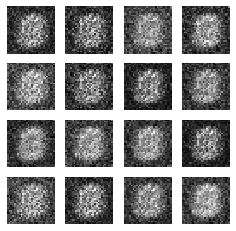

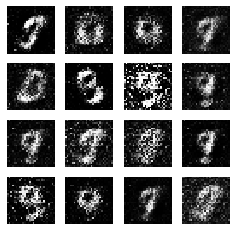

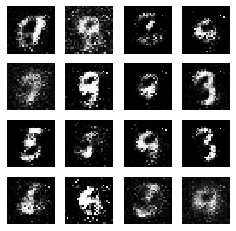

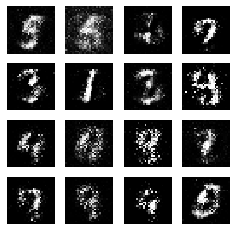

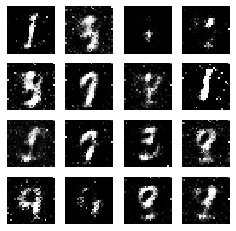

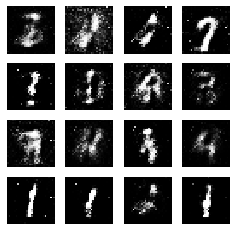

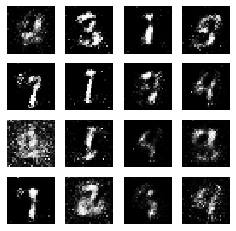

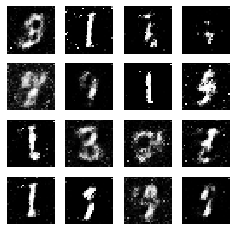

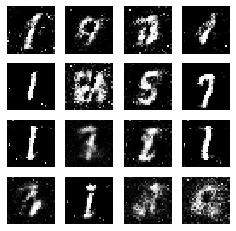

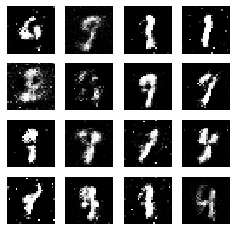

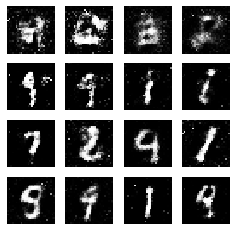

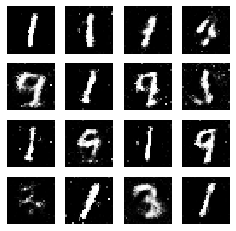

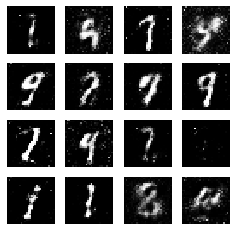

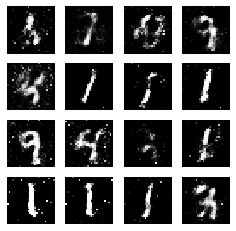

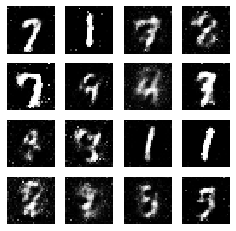

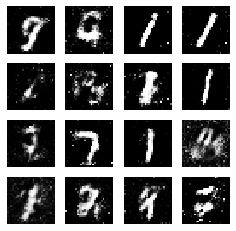

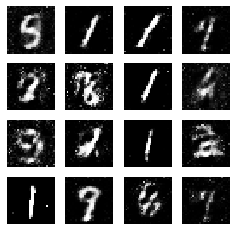

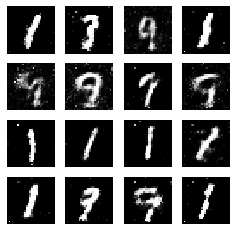

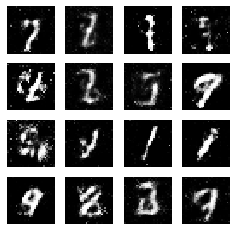

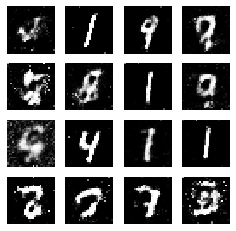

In [9]:
iteractions = 20000
batch_size = 128
sample_interval = 1000

# Train the GAN
train(iteractions, batch_size, sample_interval)

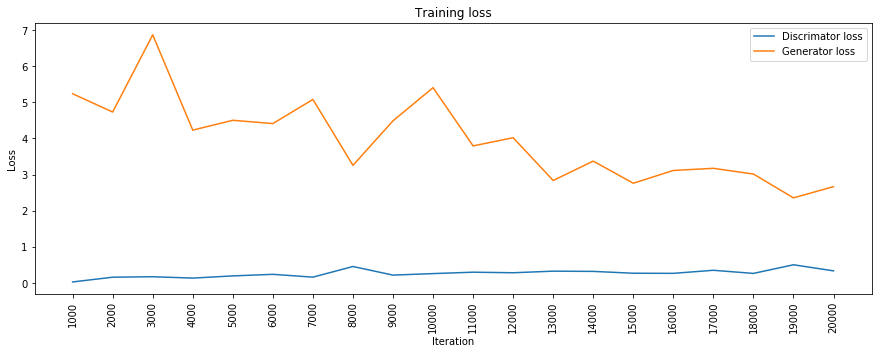

In [10]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discrimator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title('Training loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

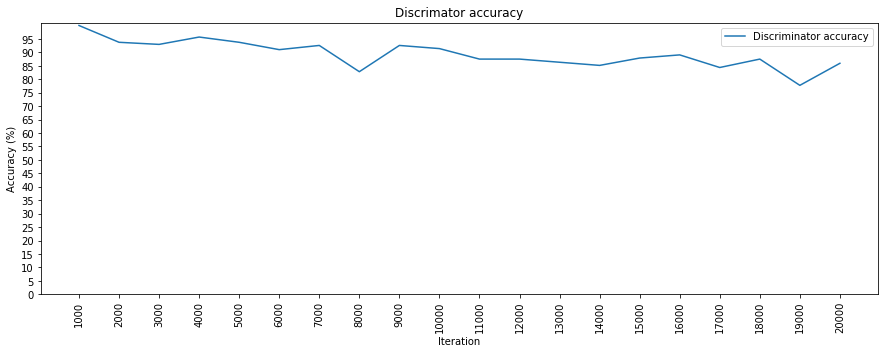

In [11]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label='Discriminator accuracy')
plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title('Discrimator accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%)')
plt.legend()